In [1]:
import math
import random
import numpy as np
from PIL import Image
import cv2
import torch
import random
import librosa
import numpy as np
import os
import librosa
import numpy as np
import pandas as pd
import glob
from pathlib import Path
from torch.utils.data import DataLoader

from tensorflow.keras.models import load_model

2024-03-18 12:48:31.050131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 12:48:31.050229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 12:48:31.168777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(1234)

In [3]:
# Source: https://www.kaggle.com/davids1992/specaugment-quick-implementation
def spec_augment(spec: np.ndarray,
                 num_mask=2,
                 freq_masking=0.15,
                 time_masking=0.20,
                 value=0):
    spec = spec.copy()
    num_mask = random.randint(1, num_mask)
    for i in range(num_mask):
        all_freqs_num, all_frames_num  = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking)

        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[f0:f0 + num_freqs_to_mask, :] = value

        time_percentage = random.uniform(0.0, time_masking)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[:, t0:t0 + num_frames_to_mask] = value
    return spec

In [4]:
#Source: https://github.com/lRomul/argus-freesound/blob/master/src/transforms.py
class SpecAugment:
    def __init__(self,
                 num_mask=2,
                 freq_masking=0.15,
                 time_masking=0.20):
        self.num_mask = num_mask
        self.freq_masking = freq_masking
        self.time_masking = time_masking

    def __call__(self, image):
        return spec_augment(image,
                            self.num_mask,
                            self.freq_masking,
                            self.time_masking,
                            image.min())

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, trg=None):
        if trg is None:
            for t in self.transforms:
                image = t(image)
            return image
        else:
            for t in self.transforms:
                image, trg = t(image, trg)
            return image, trg
        
class UseWithProb:
    def __init__(self, transform, prob=.5):
        self.transform = transform
        self.prob = prob

    def __call__(self, image, trg=None):
        if trg is None:
            if random.random() < self.prob:
                image = self.transform(image)
            return image
        else:
            if random.random() < self.prob:
                image, trg = self.transform(image, trg)
            return image, trg
        
class OneOf:
    def __init__(self, transforms, p=None):
        self.transforms = transforms
        self.p = p

    def __call__(self, image, trg=None):
        transform = np.random.choice(self.transforms, p=self.p)
        if trg is None:
            image = transform(image)
            return image
        else:
            image, trg = transform(image, trg)
            return image, trg
        
class ImageToTensor:
    def __call__(self, image):
        delta = librosa.feature.delta(image)
        accelerate = librosa.feature.delta(image, order=2)
        image = np.stack([image, delta, accelerate], axis=0)
        # image = np.stack([image, image, image], axis=0)
        image = image.astype(np.float32) / 100
        image = torch.from_numpy(image)
        return image
    
class RandomCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, signal):
        start = random.randint(0, signal.shape[1] - self.size)
        return signal[:, start: start + self.size]

class CenterCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, signal):

        if signal.shape[1] > self.size:
            start = (signal.shape[1] - self.size) // 2
            return signal[:, start: start + self.size]
        else:
            return signal
        
class PadToSize:
    def __init__(self, size, mode='constant'):
        assert mode in ['constant', 'wrap']
        self.size = size
        self.mode = mode

    def __call__(self, signal):
        if signal.shape[1] < self.size:
            padding = self.size - signal.shape[1]
            offset = padding // 2
            pad_width = ((0, 0), (offset, padding - offset))
            if self.mode == 'constant':
                signal = np.pad(signal, pad_width,
                                'constant', constant_values=signal.min())
            else:
                signal = np.pad(signal, pad_width, 'wrap')
        return signal
    

In [5]:
def get_transforms(train, size,
                   wrap_pad_prob=0.5,
                   resize_prob=0.33,
                   spec_num_mask=2,
                   spec_freq_masking=0.15,
                   spec_time_masking=0.20,
                   spec_prob=0.5):
    if train:
        transforms = Compose([
            OneOf([
                PadToSize(size, mode='wrap'),
                PadToSize(size, mode='constant'),
            ], p=[wrap_pad_prob, 1 - wrap_pad_prob]),
            PadToSize(size),
            RandomCrop(size),
            UseWithProb(SpecAugment(num_mask=spec_num_mask,
                                    freq_masking=spec_freq_masking,
                                    time_masking=spec_time_masking), spec_prob),
            ImageToTensor()
        ])
    else:
        transforms = Compose([
            PadToSize(size),
            CenterCrop(size),
            ImageToTensor()
        ])
    return transforms

In [6]:
def read_as_melspectrogram(file_path):
    y, sr = librosa.load(file_path, sr=48000)
    yt, idx = librosa.effects.trim(y) #trim leading and trailing silence from an audio signal

    spectrogram = librosa.feature.melspectrogram(y=yt,
                                                 sr=48000,
                                                 n_mels=150,
                                                 hop_length=345 * 5,                                            
                                                 n_fft=315 * 20,
                                                 fmin=20,
                                                 fmax=48000//4)
                                                
    spectrogram = librosa.power_to_db(spectrogram)
    librosa.display.specshow(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [7]:
def get_data(indexes, wav_paths):
    folds_df = pd.read_csv("/kaggle/input/dataset-label/label_data.csv", delimiter=";")
    targets_lst = folds_df.loc[indexes]["label"]

    images_lst = []
    for i in wav_paths:
        images_lst.append(read_as_melspectrogram(i))

    return list(targets_lst), images_lst 

In [8]:
class NewDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, train=True, seed=42):
        self.transform = transform
        
        self.wav_path = []
        for wav_path in sorted(root.glob('*.wav')):
            self.wav_path.append(wav_path)
        
        np.random.seed(seed)
        permutation = np.random.permutation(len(self.wav_path))
        
        # Train/test split
        if train:
            self.indexes = permutation[: int(len(self.wav_path) * 0.8)].tolist()
        else:
            self.indexes = permutation[int(len(self.wav_path) * 0.8) :].tolist()
  
        self.wav_path = [self.wav_path[wav] for wav in self.indexes]
        
        self.target, self.image = get_data(self.indexes, self.wav_path)
        

    def __getitem__(self, idx):
        image = self.image[idx]
        target = self.target[idx]
        
        return self.transform(image=image), target
        
    def __len__(self):
        return len(self.target)

In [9]:
train_transfrom = get_transforms(train=True,
                                     size=256,
                                     wrap_pad_prob=0.5,
                                     resize_prob=0.33,
                                     spec_num_mask=2,
                                     spec_freq_masking=0.15,
                                     spec_time_masking=0.20,
                                     spec_prob=0.5)

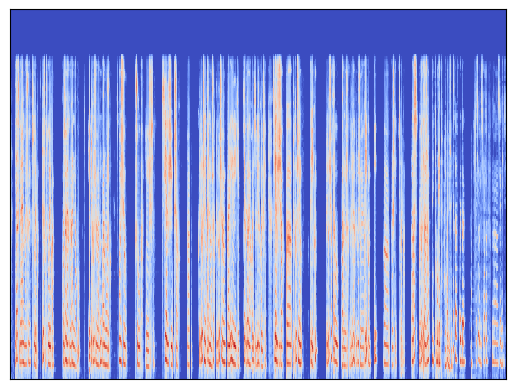

In [10]:
train_ds = NewDataset(root=Path("/kaggle/input/dataset-audio"), transform=train_transfrom, train=True)
test_ds = NewDataset(root=Path("/kaggle/input/dataset-audio"), transform=get_transforms(False, 256), train=False)

In [11]:
batch_size = 16
num_workers = 4
pin_memory =True
train_dl = DataLoader(train_ds, batch_size, True, num_workers=num_workers, pin_memory=pin_memory)
val_dl = DataLoader(test_ds, 1, True, num_workers=num_workers, pin_memory=pin_memory)

print(len(train_dl.dataset))
print(len(val_dl.dataset))

248
62


# MODEL

In [12]:
import torch
from torch import nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = F.avg_pool2d(x, 2)
        return x


class IdentityBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super(IdentityBlock, self).__init__()

        self.conv_block = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False)
        self.batch = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.scale_factor = scale_factor

    def forward(self, x):
        if self.scale_factor >= 2:
            x = F.avg_pool2d(x, self.scale_factor)
        x = self.conv_block(x)
        x = self.batch(x)
        x = self.relu(x)
        return x


class Shico_model(nn.Module):
    def __init__(self, num_classes=2, base_size=64,
                 dropout=0.2, ratio=16, kernel_size=7,
                 last_filters=8, last_fc=2):
        super().__init__()

        self.conv_block1 = ConvBlock(in_channels=3, out_channels=base_size)
        self.iden1 = IdentityBlock(in_channels=base_size, out_channels=base_size*8,
                               scale_factor=8)

        self.conv_block2 = ConvBlock(in_channels=base_size, out_channels=base_size*2)
        self.iden2 = IdentityBlock(in_channels=base_size * 2, out_channels=base_size*8,
                               scale_factor=4)

        self.conv_block3 = ConvBlock(in_channels=base_size*2, out_channels=base_size*4)
        self.iden3 = IdentityBlock(in_channels=base_size*4, out_channels=base_size*8,
                               scale_factor=2)

        self.conv_block4 = ConvBlock(in_channels=base_size*4, out_channels=base_size*8)

        self.merge = IdentityBlock(base_size*8*4, base_size*last_filters, 1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.lin = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_size*last_filters, base_size*last_fc),
            nn.PReLU(),
            nn.BatchNorm1d(base_size*last_fc),
            nn.Dropout(dropout/2),
            nn.Linear(base_size*last_fc, num_classes),
        )


    def forward(self, x):
        x = self.conv_block1(x)
        iden1 = self.iden1(x)

        x = self.conv_block2(x)
        iden2 = self.iden2(x)

        x = self.conv_block3(x)
        iden3 = self.iden3(x)

        x = self.conv_block4(x)

        x = torch.cat([x, iden1, iden2, iden3], dim=1)

        x = self.merge(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.lin(x)
        return x

In [13]:
from  torch.nn import CrossEntropyLoss

leaing_rate = 0.001

loss_fun=CrossEntropyLoss()

net=Shico_model().cuda()

opt = torch.optim.Adam(params=net.parameters(), lr=leaing_rate)

lr_decay = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[10,20])
#lr_decay = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
seed_everything(1234)

for epoch in range(100):
    net.train()

    mean_loss = []

    for batch in train_dl:
    
        images, targets = batch[0], batch[1]
        images, targets = images.to(device), targets.to(device)
        
        predictions = net(images)

        # calculating loss
        loss = loss_fun(predictions.cpu(), targets.cpu())

        # backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_decay.step()

        mean_loss.append(loss.item())
        
    print(f"Epoch {epoch} done Train loss {np.mean(mean_loss):.3f} ")

Epoch 0 done Train loss 0.850 
Epoch 1 done Train loss 0.608 
Epoch 2 done Train loss 0.661 
Epoch 3 done Train loss 0.657 
Epoch 4 done Train loss 0.660 
Epoch 5 done Train loss 0.616 
Epoch 6 done Train loss 0.656 
Epoch 7 done Train loss 0.600 
Epoch 8 done Train loss 0.595 
Epoch 9 done Train loss 0.615 
Epoch 10 done Train loss 0.667 
Epoch 11 done Train loss 0.655 
Epoch 12 done Train loss 0.608 
Epoch 13 done Train loss 0.601 
Epoch 14 done Train loss 0.626 
Epoch 15 done Train loss 0.664 
Epoch 16 done Train loss 0.645 
Epoch 17 done Train loss 0.638 
Epoch 18 done Train loss 0.610 
Epoch 19 done Train loss 0.611 
Epoch 20 done Train loss 0.636 
Epoch 21 done Train loss 0.626 
Epoch 22 done Train loss 0.582 
Epoch 23 done Train loss 0.615 
Epoch 24 done Train loss 0.591 
Epoch 25 done Train loss 0.600 
Epoch 26 done Train loss 0.572 
Epoch 27 done Train loss 0.601 
Epoch 28 done Train loss 0.591 
Epoch 29 done Train loss 0.603 
Epoch 30 done Train loss 0.653 
Epoch 31 done Trai

In [16]:
def validation(model, optimizer, test_loader,isval=True):
    model.eval()
    pre_all=[]
    tre_all=[]

    test_loss = 0
    all_y = []
    all_y_pred = []

    prob_all=[]
    num = 0
    with torch.no_grad():
        for X, y  in test_loader:
            all_y.append(y.cpu().numpy())
            tre=y
            y = y.type(torch.LongTensor).cuda()
            num=num+1

            # distribute data to device
            X= X.cuda()

            outputs = model(X)

            loss= loss_fun(outputs, y)

            mask=outputs.cpu().numpy()

            tmp_prob=mask[:,1]

            prob_all.extend(tmp_prob)

            tmp=np.argmax(mask, 1)

            all_y_pred.append(tmp)

            test_loss += loss.item()  

    test_loss /= num
    test_loss=test_loss

    y_true=np.array(all_y)
    y_pre=np.array(all_y_pred)

    acc_sk=accuracy_score(y_true,y_pre)
    precis=precision_score(y_true,y_pre)
    recall=recall_score(y_true,y_pre)
    f1=f1_score(y_true,y_pre)


    return f'test_loss = {test_loss}, accuracy = {acc_sk}, precision = {precis}, recall = {recall},f1 = {f1}'


In [18]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

metric = validation(net, opt, val_dl)
print(metric)
#print(f'Output: {list(output)}, True: {list(true)}')

test_loss = 0.3714328891552624, accuracy = 0.8225806451612904, precision = 0.7567567567567568, recall = 0.9333333333333333,f1 = 0.835820895522388
